# Import Packages

In [40]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, SimpleRNN, GRU
from tensorflow.keras.utils import timeseries_dataset_from_array


# Load Data

In [41]:
# Load the data
raw_data = pd.read_csv('proc_data_train.csv')


# Preprocessing data

In [42]:
# Creating Defect Categoical attribute
raw_data['Defect'] = (raw_data['perc_defects_Sidewall'] > 0.02).astype(int)

#Drop unnessacary columns
data = raw_data.drop(['final_time', 'reference', 'production', 'rejected_Sidewall', 'total_Sidewall'], axis=1)
data['initial_time'] = pd.to_datetime(data['initial_time'])

#Create dummy variables for categorical attributes
data[['cavity', 'section']] = data[['cavity', 'section']].astype('category')
dummy_variables = pd.get_dummies(data[['cavity', 'section']], drop_first=True).astype(int)

#rejoin the dummy variables to the data
data = pd.concat([data, dummy_variables], axis=1)
data = data.drop(['cavity', 'section'], axis=1)



In [43]:
# Prepare the data for the GRU model
data = data.drop(['initial_time'], axis=1)
features = data.drop(['perc_defects_Sidewall', 'Defect'], axis=1)
target_regression = data['perc_defects_Sidewall']
target_classification = data['Defect']

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


# Data Split

In [44]:
# Split the data: 80% train, 10% validation, 10% holdout
train_size = int(0.8 * len(features_scaled))
val_size = int(0.1 * len(features_scaled))

features_train = features_scaled[:train_size]
features_val = features_scaled[train_size:train_size + val_size]
features_holdout = features_scaled[train_size + val_size:]

target_reg_train = target_regression[:train_size]
target_reg_val = target_regression[train_size:train_size + val_size]
target_reg_holdout = target_regression[train_size + val_size:]

target_class_train = target_classification[:train_size]
target_class_val = target_classification[train_size:train_size + val_size]
target_class_holdout = target_classification[train_size + val_size:]


# Creation of Timeseries datasets

In [45]:

sampling_rate = 1  
sequence_length = 50  
batch_size = 124

# Create time series datasets
def create_timeseries_dataset(features, target_reg, target_class, sequence_length, batch_size):
    inputs = timeseries_dataset_from_array(
        features,
        None,
        sequence_length=sequence_length,
        batch_size=batch_size,
        shuffle=False
    )

    targets_reg = timeseries_dataset_from_array(
        target_reg[sequence_length - 1:],
        None,
        sequence_length=1,
        batch_size=batch_size,
        shuffle=False
    )

    targets_class = timeseries_dataset_from_array(
        target_class[sequence_length - 1:],
        None,
        sequence_length=1,
        batch_size=batch_size,
        shuffle=False
    )

    dataset = tf.data.Dataset.zip((inputs, tf.data.Dataset.zip((targets_reg, targets_class))))
    return dataset

train_dataset = create_timeseries_dataset(features_train, target_reg_train, target_class_train, sequence_length, batch_size)
validation_dataset = create_timeseries_dataset(features_val, target_reg_val, target_class_val, sequence_length, batch_size)
holdout_dataset = create_timeseries_dataset(features_holdout, target_reg_holdout, target_class_holdout, sequence_length, batch_size)


# Models

## LSTM

In [48]:
# Build the LSTM model
input_shape = (sequence_length, features_train.shape[1])

base_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(input_shape)),
    Dropout(0.5),
    LSTM(64, return_sequences=False),
    Dropout(0.25)
])

inputs = Input(shape=input_shape)

x= base_model(inputs)
regression_output = Dense(1, name='regression_output')(x)
classification_output = Dense(1, activation='sigmoid', name='classification_output')(x)

model_lstm = Model(inputs=inputs, outputs=[regression_output, classification_output])
model_lstm.compile(optimizer='adam', 
              loss={'regression_output': 'mean_squared_error', 'classification_output': 'binary_crossentropy'},
              metrics={'regression_output': 'mean_squared_error', 'classification_output': [tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()]})

model_lstm.summary()

callbacks = [ keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss") ]

# Train the model
history_lstm = model_lstm.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset#,
    callbacks=callbacks
)



Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27      │ (None, 50, 241)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_13       │ (None, 64)        │    111,360 │ input_layer_27[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regression_output   │ (None, 1)         │         65 │ sequential_13[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification_out… │ (None, 1)         │         65 │ sequential_13[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 111,490 (435.51 KB)

 Trainable params: 111,490 (435.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 257s 164ms/step - classification_output_auc_13: 0.6005 - classification_output_binary_accuracy: 0.8053 - loss: 0.4960 - regression_output_mean_squared_error: 0.0122 - val_classification_output_auc_13: 0.6049 - val_classification_output_binary_accuracy: 0.8295 - val_loss: 0.4473 - val_regression_output_mean_squared_error: 4.1443e-04
Epoch 2/10
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 313s 202ms/step - classification_output_auc_13: 0.6475 - classification_output_binary_accuracy: 0.8116 - loss: 0.4641 - regression_output_mean_squared_error: 5.0975e-04 - val_classification_output_auc_13: 0.6147 - val_classification_output_binary_accuracy: 0.8271 - val_loss: 0.4426 - val_regression_output_mean_squared_error: 3.4137e-04
Epoch 3/10
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 298s 193ms/step - classification_output_auc_13: 0.6833 - classification_output_binary_accuracy: 0.8160 - loss: 0.4488 - regression_output_mean_squared_error: 3.9407e-04 - val_classification_output_auc_1

## RRN

In [49]:
# Build the RNN model
input_shape = (sequence_length, features_train.shape[1])

base_model = Sequential([
    SimpleRNN(64, return_sequences=True, input_shape=(input_shape)),
    Dropout(0.5),
    SimpleRNN(64, return_sequences=False),
    Dropout(0.25)
])

inputs = Input(shape=input_shape)

x= base_model(inputs)
regression_output = Dense(1, name='regression_output')(x)
classification_output = Dense(1, activation='sigmoid', name='classification_output')(x)

model_rnn = Model(inputs=inputs, outputs=[regression_output, classification_output])
model_rnn.compile(optimizer='adam', 
              loss={'regression_output': 'mean_squared_error', 'classification_output': 'binary_crossentropy'},
              metrics={'regression_output': 'mean_squared_error', 'classification_output': [tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()]})

model_rnn.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss") ]

# Train the model
history_rrn = model_rnn.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset#,
    callbacks=callbacks
)


c:\Users\Naik2\Desktop\Portugal\Uni\APA\apa\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_44"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_29      │ (None, 50, 241)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_14       │ (None, 64)        │     27,840 │ input_layer_29[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regression_output   │ (None, 1)         │         65 │ sequential_14[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification_out… │ (None, 1)         │         65 │ sequential_14[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 27,970 (109.26 KB)

 Trainable params: 27,970 (109.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 132s 82ms/step - classification_output_auc_14: 0.5726 - classification_output_binary_accuracy: 0.7666 - loss: 0.7596 - regression_output_mean_squared_error: 0.2269 - val_classification_output_auc_14: 0.5705 - val_classification_output_binary_accuracy: 0.7999 - val_loss: 0.4909 - val_regression_output_mean_squared_error: 3.1769e-04
Epoch 2/10
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 125s 81ms/step - classification_output_auc_14: 0.6106 - classification_output_binary_accuracy: 0.8059 - loss: 0.4812 - regression_output_mean_squared_error: 3.6768e-04 - val_classification_output_auc_14: 0.5881 - val_classification_output_binary_accuracy: 0.8094 - val_loss: 0.4674 - val_regression_output_mean_squared_error: 2.9798e-04
Epoch 3/10
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 117s 76ms/step - classification_output_auc_14: 0.6409 - classification_output_binary_accuracy: 0.8089 - loss: 0.4670 - regression_output_mean_squared_error: 4.1679e-04 - val_classification_output_auc_14: 

## GRU

In [50]:
# Build the GRU model
input_shape = (sequence_length, features_train.shape[1])

base_model = Sequential([
    GRU(64, return_sequences=True, input_shape=(input_shape)),
    Dropout(0.5),
    GRU(64, return_sequences=False),
    Dropout(0.25)
])

inputs = Input(shape=input_shape)

x= base_model(inputs)
regression_output = Dense(1, name='regression_output')(x)
classification_output = Dense(1, activation='sigmoid', name='classification_output')(x)

model_gru = Model(inputs=inputs, outputs=[regression_output, classification_output])
model_gru.compile(optimizer='adam', 
              loss={'regression_output': 'mean_squared_error', 'classification_output': 'binary_crossentropy'},
              metrics={'regression_output': 'mean_squared_error', 'classification_output': [tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()]})

model_gru.summary()

callbacks = [ keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss") ]

# Train the model
history_gru= model_gru.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset#,
    callbacks = callbacks
)

Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_31      │ (None, 50, 241)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_15       │ (None, 64)        │     83,904 │ input_layer_31[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regression_output   │ (None, 1)         │         65 │ sequential_15[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification_out… │ (None, 1)         │         65 │ sequential_15[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,034 (328.26 KB)

 Trainable params: 84,034 (328.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 393s 251ms/step - classification_output_auc_15: 0.5974 - classification_output_binary_accuracy: 0.7926 - loss: 0.5694 - regression_output_mean_squared_error: 0.0724 - val_classification_output_auc_15: 0.5941 - val_classification_output_binary_accuracy: 0.8201 - val_loss: 0.4567 - val_regression_output_mean_squared_error: 4.7164e-04
Epoch 2/10
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 380s 246ms/step - classification_output_auc_15: 0.6363 - classification_output_binary_accuracy: 0.8090 - loss: 0.4698 - regression_output_mean_squared_error: 9.7114e-04 - val_classification_output_auc_15: 0.5957 - val_classification_output_binary_accuracy: 0.8068 - val_loss: 0.4632 - val_regression_output_mean_squared_error: 3.2955e-04
Epoch 3/10
1544/1544 ━━━━━━━━━━━━━━━━━━━━ 398s 258ms/step - classification_output_auc_15: 0.6864 - classification_output_binary_accuracy: 0.8136 - loss: 0.4496 - regression_output_mean_squared_error: 3.7229e-04 - val_classification_output_auc_1

# Evaluate Models

In [51]:
# Evaluate on holdout set
holdout_eval_lstm = model_lstm.evaluate(holdout_dataset)
print(f"Holdout set evaluation: {holdout_eval_lstm}")

193/193 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - classification_output_auc_13: 0.7229 - classification_output_binary_accuracy: 0.7919 - loss: 0.4546 - regression_output_mean_squared_error: 3.0638e-04
Holdout set evaluation: [0.4815775156021118, 0.6990005970001221, 0.7846166491508484, 0.00031852396205067635]


In [52]:

# Evaluate on holdout set
holdout_eval_rrn = model_rnn.evaluate(holdout_dataset)
print(f"Holdout set evaluation: {holdout_eval_rrn}")

193/193 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - classification_output_auc_14: 0.6774 - classification_output_binary_accuracy: 0.7685 - loss: 0.4870 - regression_output_mean_squared_error: 3.8608e-04
Holdout set evaluation: [0.5284311771392822, 0.6422044038772583, 0.7329062223434448, 0.00043501719483174384]


In [53]:
# Evaluate on holdout set
holdout_eval_gru = model_gru.evaluate(holdout_dataset)
print(f"Holdout set evaluation: {holdout_eval_gru}")

193/193 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - classification_output_auc_15: 0.6917 - classification_output_binary_accuracy: 0.7698 - loss: 0.4975 - regression_output_mean_squared_error: 3.4840e-04
Holdout set evaluation: [0.5255452394485474, 0.6708288192749023, 0.7648118138313293, 0.000367813219781965]


# Save Models

In [54]:
# Save the models
model_gru.save('model_gru.keras')
model_lstm.save('model_lstm.keras')
model_rnn.save('model_rrn.keras')

# Graphs

193/193 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step


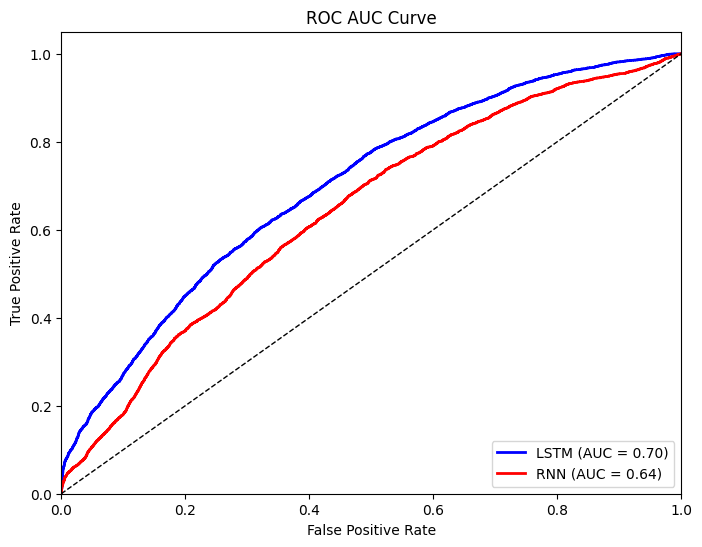

In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# LSTM model ROC AUC curve
y_pred_lstm = model_lstm.predict(holdout_dataset)
fpr_lstm, tpr_lstm, _ = roc_curve(target_class_holdout[sequence_length - 1:], y_pred_lstm[1])
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

# RNN model ROC AUC curve
y_pred_rnn = model_rnn.predict(holdout_dataset)
fpr_rnn, tpr_rnn, _ = roc_curve(target_class_holdout[sequence_length - 1:], y_pred_rnn[1])
roc_auc_rnn = auc(fpr_rnn, tpr_rnn)

# Plot ROC AUC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_lstm, tpr_lstm, color='blue', lw=2, label=f'LSTM (AUC = {roc_auc_lstm:.2f})')
plt.plot(fpr_rnn, tpr_rnn, color='red', lw=2, label=f'RNN (AUC = {roc_auc_rnn:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc="lower right")
plt.show()

In [57]:
model_gru.predict(holdout_dataset)[1]

193/193 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step


array([[0.05342983],
       [0.04990461],
       [0.04932946],
       ...,
       [0.0663072 ],
       [0.06714711],
       [0.0661488 ]], dtype=float32)